# **Applied AI in Biomedicine - Final Assignment**
## PAC/PVC classification from ECG signals
***
* Alberto Rota: *Person Code: 10615751 - Student Number: 964662 - [alberto2.rota@mail.polimi.it](mailto:alberto2.rota@mail.polimi.it)*  
* Gabriele Santicchi: *Person Code: 10579046 - Student Number: 969088 - [gabriele.santicchi@mail.polimi.it](mailto:gabriele.santicchi@mail.polimi.it)*
***

In [10]:
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.sans-serif'] = "Times New Roman"
import seaborn as sns
import tarfile
import math
import random
import sklearn
import timeit
import json
import warnings
import random

import scipy
from scipy.io import loadmat
from random import randint

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing 
import sklearn
from sklearn.model_selection import train_test_split

SEED = 69
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Using Tensorflow version",tf.__version__)
print("RNG seed:", SEED)

color = {
    "lead": "#073b4c",
    "N": "#06d6a0",
    "S": "#ef476f",
    "V": "#ffd166",
    "X": "#118ab2",
}

Using Tensorflow version 2.6.0
RNG seed: 69


In [2]:
dataset_dir = "data"

## Patient class definition

In [3]:
class Patient:
    def __init__(self,init_dict):
        self.path=init_dict['path']
        self.fs=init_dict['fs']
        self.id=init_dict['id']
        self.rpeaks=init_dict['rpeaks']
        self.peaklabels=init_dict['peaklabels']
        self.samples=init_dict['samples']
        self.time=np.arange(0,self.samples/self.fs,1/self.fs)
        self.lead1=init_dict['lead1']
        self.lead2=init_dict['lead2']
        if self.fs != 128:
            f1 = scipy.interpolate.interp1d(self.time,self.lead1)
            f2 = scipy.interpolate.interp1d(self.time,self.lead2)
            self.time=np.arange(0,self.samples/self.fs,1/self.fs)
            self.fs = 128.0
            self.lead1 = f1(self.time)
            self.lead2 = f2(self.time)
        
        insideborders = np.logical_and(self.rpeaks>0, self.rpeaks<self.samples)
        
        if self.rpeaks.shape[0]-np.count_nonzero(insideborders)>0: 
            print(f"PATIENT {self.id}: Found {self.rpeaks.shape[0]-np.count_nonzero(insideborders)} samples out of bounds")
            self.rpeaks = self.rpeaks[insideborders]
            self.peaklabels = self.peaklabels[insideborders]
                                
    def info(self):
        print(">> ID:",self.id)
        print(" | Path:",self.path)
        print(" | fs:",self.fs)
        print(" | samples:",self.samples)
        print(" | lead1:",self.lead1)
        print(" | lead2:",self.lead2)
        print(" | rpeaks:",self.rpeaks)
        print(" | peaklabels:",self.peaklabels)
        
    def plot(self,windowstart=None,xrange=4000,splitleads=False):
        if windowstart is None: windowstart = randint(0,self.samples-xrange)
        
        if not splitleads: 
            plt.figure(figsize=(10,7))
            plt.subplot(2,1,1)
        if splitleads: plt.figure(figsize=(10,2.5))
        plt.plot(self.time,self.lead1,color=color['lead'])
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='N']],
            color=color['N'],s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='S']],
            color=color['S'],s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='V']],
            color=color['V'],s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title(f"Patient #{self.id} - ECG lead 1")
        if splitleads: plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if splitleads: plt.show()
        
        if not splitleads: 
            plt.subplot(2,1,2)
        if splitleads: plt.figure(figsize=(10,2.5))
        plt.plot(self.time,self.lead2,color=color['lead'])
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='N']],
            color=color['N'],s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='S']],
            color=color['S'],s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='V']],
            color=color['V'],s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title(f"Patient #{self.id} - ECG lead 2")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    def split_RRR(self,borders=0.05, fixed_length=False):
        border_samples = round(borders*(self.rpeaks[0]))
        
        wl1 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        wl2 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        
        for p in range(1,self.rpeaks.shape[0]-1):
            border_samples = round(borders*(self.rpeaks[p+1]-self.rpeaks[p-1]))
            window = self.lead1[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl1.append(window)
            window = self.lead2[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl2.append(window)
        
        border_samples = round(borders*(self.rpeaks[0]))
        wl1.append(self.lead1[self.rpeaks[-1]:self.samples])
        wl2.append(self.lead1[self.rpeaks[-1]:self.samples])
        
        if fixed_length != False:
            r1,r2 = [],[]
            for i,_ in enumerate(wl1):
                if wl1[i].shape[0] >= fixed_length:
                    r1.append(
                        wl1[i][wl1[i].shape[0]//2-fixed_length//2:wl1[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                    r2.append(
                        wl2[i][wl2[i].shape[0]//2-fixed_length//2:wl2[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                elif wl1[i].shape[0] < fixed_length:
                    padleft  = (fixed_length-wl1[i].shape[0])//2
                    padright = fixed_length-padleft-wl1[i].shape[0]
                    r1.append(
                        np.pad(wl1[i], (padleft,padright), mode='edge')
                    )
                    r2.append(
                        np.pad(wl2[i], (padleft,padright), mode='edge')
                    )
                elif wl1[i].shape[0] == fixed_length:
                    r1.append(
                        wl1[i][-fixed_length:]
                    )
                    r2.append(
                        wl2[i][-fixed_length:]
                    )
            wl1,wl2 = r1,r2
        return wl1,wl2
        
    def split_windows(self, width=100):
        wl1,wl2=[],[]
        
        right = width//2
        left = width-right
        LEN = self.lead1.shape[0]

        for i in range(self.rpeaks.shape[0]):
            peak = self.rpeaks[i]
            
            if peak-left >= 0 and peak+right < LEN: 
                window = self.lead1[(peak-left):(peak+right)]
            elif peak-left < 0:
                window = np.pad(self.lead1[0:(peak+right)],(abs(width-(peak+right)),0))
                
            elif peak+right >= LEN:
                window = np.pad(self.lead1[(peak-left):LEN],(0,abs(width-(LEN-(peak-left)))))
                
            wl1.append(window)
            
            if peak-left >= 0 and peak+right < LEN: 
                window = self.lead2[(peak-left):(peak+right)]
            elif peak-left < 0:
                window = np.pad(self.lead2[0:(peak+right)],(abs(width-(peak+right)),0))
                
            elif peak+right >= LEN:
                window = np.pad(self.lead2[(peak-left):LEN],(0,abs(width-(LEN-(peak-left)))))
            
            wl2.append(window)

        return wl1,wl2
    
    def countnans(self):
        return np.count_nonzero(np.isnan(self.lead1))+np.count_nonzero(np.isnan(self.lead2))

## Data Loading

In [4]:
files = sorted(os.listdir(dataset_dir))
patient = []
correct,ncorrect=0,0
nans=0
for f in range(0,len(files),3):
    try: 
        recs = loadmat(os.path.join(dataset_dir,files[f]))
        ann = loadmat(os.path.join(dataset_dir,files[f+1]))
        rp =loadmat(os.path.join(dataset_dir,files[f+2]))
        patient_as_dict={
                'id':files[f].split(".")[0].split("_")[0],
                'path':os.path.join("data",files[f]),
                'fs':float(files[f].split(".")[0].split("_")[1]),
                'samples':recs['ecg'][:,0].shape[0],
                'lead1':recs['ecg'][:,0],
                'lead2':recs['ecg'][:,1],
                'rpeaks':rp['rpeaks'].T[0],
                'peaklabels':ann['labels'] 
        }
        patient.append(Patient(patient_as_dict))
        nans += patient[-1].countnans()
        correct+=1
        
    except:
        ncorrect+=1
        
print(f"Loaded {correct} files correctly")
if ncorrect>0: print(f"!!!! Error in loading {ncorrect} files")
if nans>0: print("Found: ",nans, "missing values")
ptest = patient[9] # Test patient

PATIENT S005: Found 1 samples out of bounds
PATIENT S009: Found 1 samples out of bounds
Loaded 105 files correctly


### Examples of ECG signals

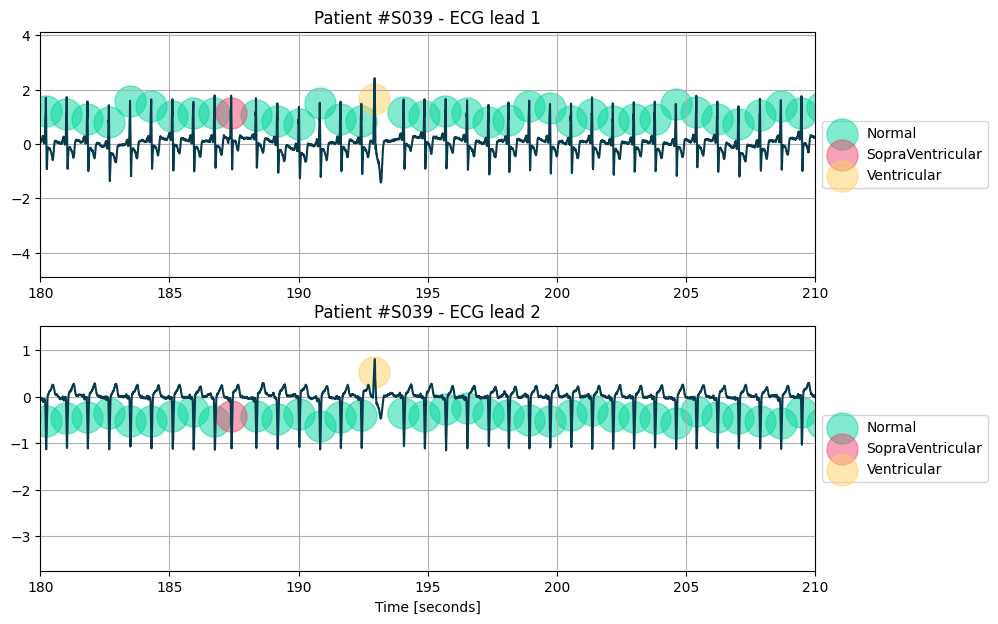

In [5]:
patient[38].plot(180*patient[38].fs,30*patient[38].fs) # 1 Sopraventricular, 1 Ventricular
# patient[13].plot() # Lots of Sopraventriculars
# patient[9].plot() # Lots of both Sopraventriculars and Ventriculars
# patient[0].plot(60000,5000) # Baseline wonder

## Window splitting

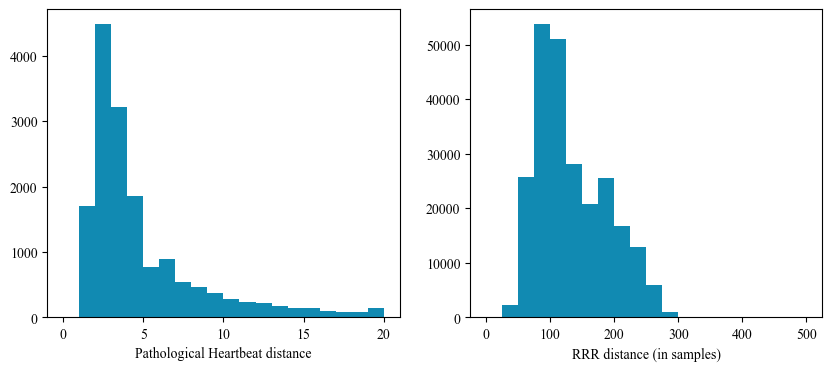

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

ints = []
wins = []
N_count = 0
S_count = 0
V_count = 0

for ptest in patient:
    nn = np.where(np.logical_or(ptest.peaklabels=='V',ptest.peaklabels=='S'))
    intervals = np.diff(nn)[0]
    wins.append(np.diff(ptest.rpeaks))
    ints.append(intervals)
    N_count+=np.count_nonzero(ptest.peaklabels=='N')
    S_count+=np.count_nonzero(ptest.peaklabels=='S')
    V_count+=np.count_nonzero(ptest.peaklabels=='V')
    
intervals = np.concatenate(ints,axis=0)
RRR = np.concatenate(wins,axis=0)
rng=[0,20]
plt.hist(intervals,bins=rng[-1],range=rng,color=color['X'])
# plt.xticks(range(rng[-1]))
plt.xlabel("Pathological Heartbeat distance")
# plt.grid(True)

plt.subplot(1,2,2)
plt.hist(RRR,color=color['X'], range=[0,500],bins=20)
plt.xlabel("RRR distance (in samples)")
# plt.xticks(range(rng[-1]))
# plt.title("Density of distance (in heartbeats) between adjacent pathological heartbeats")
# plt.grid(True)
plt.show()

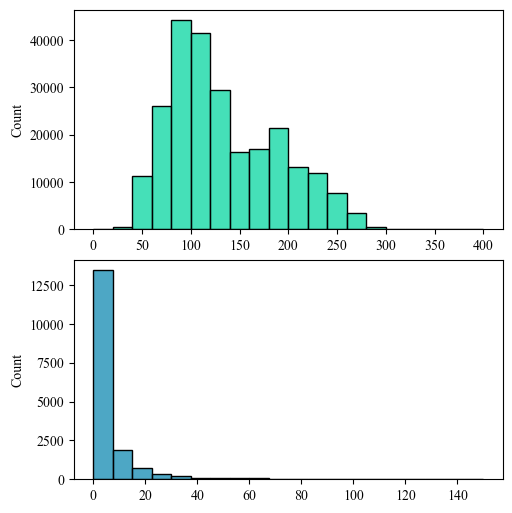

In [41]:
plt.figure(figsize=(5,5), constrained_layout=True)
plt.subplot(2,1,1)
sns.histplot(RRR,bins=20,binrange=[0,400], color = color['N'])
plt.subplot(2,1,2)
sns.histplot(intervals,bins=20,binrange=[0,150], color = color['X'])
plt.show()

Difference in splitting strategies:
* **`Split_RRR(fixed_length==False)`** keeps only the desired R-peak in the window --> INCONSISTENCY in window length

In [37]:
split1,_ = ptest.split_RRR(borders=0.05)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,3))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split1[i],color=color['S'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
    plt.xlim([-20,350])

* **`Split_RRR(fixed_length==True)`** keeps only the desired R-peak in the window and pads/cuts to fix the window width --> CONSISTENCY in window length

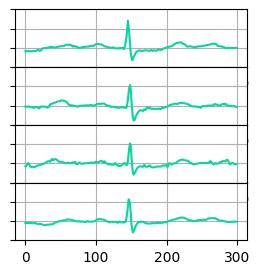

In [59]:

split1,_ = ptest.split_RRR(borders=0.05,fixed_length=300)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,3))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split1[i],color=color['N'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

* **`split_windows(width=150)`** slices a fixed number of samples around each R-peak --> Multiple peaks may appear in the same window

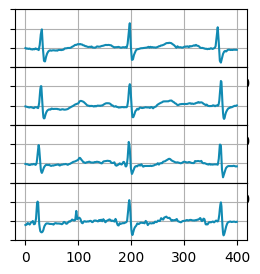

In [71]:
split1,_ = ptest.split_windows(400)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,3))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split1[i],color=color['X'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

## Label encoding
* **N**: Normal
* **S**: Sopraventricular
* **V**: Ventricular
* **X**: A virtual label used to classify the first beats in the recording, on which there is no information about the past

In [11]:
categorical = {'X':np.array([1,0,0,0]),'N':np.array([0,1,0,0]),'S':np.array([0,0,1,0]),'V':np.array([0,0,0,1])}

## Building the Dataset
And performing patient-wise undersampling on N windows

In [12]:
N_to_take = round(min([V_count,N_count,S_count])/len(patient))

def build_dataset(patients, width=150):
    XtrainWins=[]
    XtrainPast=[]
    Ytrain=[]
    for p in patients:
        split1,split2 = p.split_RRR(borders=0.05, fixed_length=width)
        vect = np.arange(0,len(split1))
        np.random.shuffle(vect)
        N = 0
        for i in vect:
            if (p.peaklabels[i] != 'N' ):
                XtrainWins.append(
                    np.column_stack((split1[i],split2[i]))
                )
                Ytrain.append(
                    categorical[p.peaklabels[i]]
                )
                if i>=2:
                    XtrainPast.append(
                        np.array([categorical[p.peaklabels[i-2]],categorical[p.peaklabels[i-1]]])
                    )
                elif i==1:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical[p.peaklabels[i-1]]])
                    )
                else:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical['X']])
                    )
            if (p.peaklabels[i] == 'N' and N < N_to_take):
                XtrainWins.append(
                np.column_stack((split1[i],split2[i]))
                )
                Ytrain.append(
                    categorical[p.peaklabels[i]]
                )
                if i>=2:
                    XtrainPast.append(
                        np.array([categorical[p.peaklabels[i-2]],categorical[p.peaklabels[i-1]]])
                    )
                elif i==1:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical[p.peaklabels[i-1]]])
                    )
                else:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical['X']])
                    )
                N = N + 1
            
    return (np.stack(XtrainWins,axis=0),np.stack(XtrainPast,axis=0)),np.stack(Ytrain,axis=0)

(XtrainW,XtrainP),Ytrain=build_dataset(patient,150)

print(f"INPUT WINDOW shape: {XtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {XtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Ytrain.shape} as (WINDOW, one-hot-LABEL)")

### Train-Test-Validation Split

In [13]:
from sklearn.model_selection import train_test_split

XtrainW,XvalW,XtrainP,XvalP,Ytrain,Yval = train_test_split(
    XtrainW,XtrainP,Ytrain, test_size=0.3, shuffle=True, stratify=Ytrain)

XvalW,XtestW,XvalP,XtestP,Yval,Ytest = train_test_split(
    XvalW,XvalP,Yval, test_size=0.3, shuffle=True, stratify=Yval)

print(f"{len(XtrainW)} TRAINING samples: {XtrainW[0].shape}[Window] + {XtrainP[0].shape}[Past Labels] --> {Ytrain[0].shape}[Classification]")
print(f"{len(XvalW)} VALIDATION samples: {XvalW[0].shape}[Window] + {XvalP[0].shape}[Past Labels] --> {Yval[0].shape}[Classification]")
print(f"{len(XtestW)} TESTING samples: {XtestW[0].shape}[Window] + {XtestP[0].shape}[Past Labels] --> {Ytest[0].shape}[Classification]")

# Building the Time Model

In [14]:
def build_time_model(inputwin_shape,inputpast_shape, classes):
    
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    x = tfkl.LSTM(128, return_sequences=True)(inputwin_layer)
    x = tfkl.Conv1D(filters = 8, kernel_size=5)(x)
    x = tfkl.LSTM(128,return_sequences=True)(x)
    x = tfkl.Dropout(.5, seed=SEED)(x)
    x = tfkl.Dense(32, activation='relu')(x)
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(classes, activation='softmax')(x)
    
    x2 = tfkl.Reshape((1,4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer,x2])
    x = tfkl.Flatten()(xc)
    output_layer = tfkl.Dense(classes,activation='softmax')(x)
    
    model = tfk.Model(inputs=[inputwin_layer,inputpast_layer], outputs=output_layer, name='PAC_PVC_classifier')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model 

timemodel = build_time_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)
timemodel.summary()
tfk.utils.plot_model(timemodel,show_shapes=True)

# Building the Frequency Model

In [35]:
def build_freq_model(inputwin_shape,inputpast_shape, classes):
    
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    x = tfkl.Conv1D(filters = 16, kernel_size=3)(inputwin_layer)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling1D(2)(x)
    x = tfkl.Conv1D(filters = 32, kernel_size=3)(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling1D(2)(x)
    x = tfkl.Dropout(.5, seed=SEED)(x)
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(64, activation='relu')(x)
    x = tfkl.Dense(classes, activation='softmax')(x)
    
    x2 = tfkl.Reshape((1,4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer,x2])
    x = tfkl.Flatten()(xc)
    output_layer = tfkl.Dense(classes,activation='softmax')(x)
    
    model = tfk.Model(inputs=[inputwin_layer,inputpast_layer], outputs=output_layer, name='PAC_PVC_classifier')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model 

freqmodel = build_freq_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)
freqmodel.summary()
tfk.utils.plot_model(freqmodel,show_shapes=True)

In [19]:
print("CLASS WEIGHTING")
N_count=np.count_nonzero(np.argmax(Ytrain,axis=1)==1)
S_count=np.count_nonzero(np.argmax(Ytrain,axis=1)==2)
V_count=np.count_nonzero(np.argmax(Ytrain,axis=1)==3)

N_samples = N_count+V_count+S_count
CLASS_WEIGHT = {
    0:0,
    1:N_samples/(3*N_count),
    2:N_samples/(3*S_count),
    3:N_samples/(3*V_count),
}
print(CLASS_WEIGHT)

# Training the Time Classifier

In [20]:
BATCH_SIZE=256
EPOCHS=100
LEARNING_RATE=1e-3

(XtrainW,XtrainP),Ytrain=build_dataset(patient,150)
print()
print(f"INPUT WINDOW shape: {XtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {XtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Ytrain.shape} as (WINDOW, one-hot-LABEL)")

XtrainW,XvalW,XtrainP,XvalP,Ytrain,Yval = train_test_split(
    XtrainW,XtrainP,Ytrain, test_size=0.3, shuffle=True, stratify=Ytrain)

XvalW,XtestW,XvalP,XtestP,Yval,Ytest = train_test_split(
    XvalW,XvalP,Yval, test_size=0.3, shuffle=True, stratify=Yval)
print()
print(f"{len(XtrainW)} TRAINING samples: {XtrainW[0].shape}[Window] + {XtrainP[0].shape}[Past Labels] --> {Ytrain[0].shape}[Classification]")
print(f"{len(XvalW)} VALIDATION samples: {XvalW[0].shape}[Window] + {XvalP[0].shape}[Past Labels] --> {Yval[0].shape}[Classification]")
print(f"{len(XtestW)} TESTING samples: {XtestW[0].shape}[Window] + {XtestP[0].shape}[Past Labels] --> {Ytest[0].shape}[Classification]")
print()
timemodel = build_time_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)

timemodel.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics = [
        'accuracy',
        tfk.metrics.Recall(class_id=1,name='recall_N'),
        tfk.metrics.Recall(class_id=2,name='recall_S'),
        tfk.metrics.Recall(class_id=3,name='recall_V'),
    ]
)

history = timemodel.fit(
    x = [XtrainW,XtrainP],
    y = Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,  
    validation_data=([XvalW,XvalP],Yval),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='recall_S', mode='max', patience=50),        
        tfk.callbacks.EarlyStopping(monitor='recall_V', mode='max', patience=50),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1)
    ],
).history

print(">> TRAINING HISTORY")
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(2,1,2)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

preds=np.argmax(timemodel.predict([XtestW, XtestP]),axis=1)
Ytestt = np.argmax(Ytest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cmt = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
hm=sns.heatmap(cm,annot=True,fmt=".2f",cmap="Greens")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.show()

# Training the Frequency classifier

In [36]:
(XtrainW,fXtrainP),fYtrain=build_dataset(patient,150)
fXtrainW = np.fft.fft(XtrainW,axis=1)

print()
print(f"INPUT WINDOW shape: {fXtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {fXtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {fYtrain.shape} as (WINDOW, one-hot-LABEL)")

fXtrainW,fXvalW,fXtrainP,fXvalP,fYtrain,fYval = train_test_split(
    fXtrainW,fXtrainP,fYtrain, test_size=0.3, shuffle=True, stratify=fYtrain)

fXvalW,fXtestW,fXvalP,fXtestP,fYval,fYtest = train_test_split(
    fXvalW,fXvalP,fYval, test_size=0.3, shuffle=True, stratify=fYval)
print()
print(f"{len(fXtrainW)} TRAINING samples: {fXtrainW[0].shape}[Window] + {fXtrainP[0].shape}[Past Labels] --> {fYtrain[0].shape}[Classification]")
print(f"{len(fXvalW)} VALIDATION samples: {fXvalW[0].shape}[Window] + {fXvalP[0].shape}[Past Labels] --> {fYval[0].shape}[Classification]")
print(f"{len(fXtestW)} TESTING samples: {fXtestW[0].shape}[Window] + {fXtestP[0].shape}[Past Labels] --> {fYtest[0].shape}[Classification]")
print()
BATCH_SIZE=64
EPOCHS=300
LEARNING_RATE=1e-3

freqmodel = build_freq_model(inputwin_shape=fXtrainW[0].shape,inputpast_shape=fXtrainP[0].shape, classes=4)

freqmodel.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics = [
        'accuracy',
        tfk.metrics.Recall(class_id=1,name='recall_N'),
        tfk.metrics.Recall(class_id=2,name='recall_S'),
        tfk.metrics.Recall(class_id=3,name='recall_V'),
    ]
)

history = freqmodel.fit(
    x = [fXtrainW,fXtrainP],
    y = fYtrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,  
    validation_data=([fXvalW,fXvalP],fYval),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='recall_S', mode='max', patience=50),        
        tfk.callbacks.EarlyStopping(monitor='recall_V', mode='max', patience=50),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
    ],
).history

print(">> TRAINING HISTORY")
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(3,1,2)
plt.plot(history['recall_S'], label='Training Recall S', alpha=.8, color='#ff0000')
plt.plot(history['val_recall_S'], label='Validation Recall S', alpha=.9, color='#ff0000')
plt.plot(history['recall_V'], label='Training Recall V', alpha=.8, color='#0000ff')
plt.plot(history['val_recall_V'], label='Validation Recall V', alpha=.9, color='#0000ff')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(3,1,3)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

preds=np.argmax(freqmodel.predict([fXtestW, fXtestP]),axis=1)
Ytestt = np.argmax(fYtest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cmf = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
hm=sns.heatmap(cm,annot=True,fmt=".2f",cmap="Blues")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.show()

# Testing and Esambling

In [59]:
timepreds = timemodel.predict([XtestW, XtestP])
freqpreds = freqmodel.predict([np.fft.fft(XtestW,axis=1), XtestP])
preds = np.argmax(timepreds+freqpreds,axis=1)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(timepreds[:,1],bins=np.arange(0,1.1,0.1))
sns.histplot(timepreds[:,2],bins=np.arange(0,1.1,0.1))
sns.histplot(timepreds[:,3],bins=np.arange(0,1.1,0.1))
plt.title("Time Model Confidence")
plt.subplot(1,2,2)
sns.histplot(freqpreds[:,1],bins=np.arange(0,1.1,0.1))
sns.histplot(freqpreds[:,2],bins=np.arange(0,1.1,0.1))
sns.histplot(freqpreds[:,3],bins=np.arange(0,1.1,0.1))
plt.title("Freq Model Confidence")
plt.show()

Ytestt = np.argmax(Ytest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cm = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
plt.figure(figsize=(15,3.5))
plt.subplot(1,3,1)
hm=sns.heatmap(cmt,annot=True,fmt=".2f",cmap="Greens")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.title("Time Model CM")
plt.subplot(1,3,2)
hm=sns.heatmap(cmf,annot=True,fmt=".2f",cmap="Blues")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
plt.title("Freq Model CM")
plt.subplot(1,3,3)
hm=sns.heatmap(cm,annot=True,fmt=".2f",cmap="Oranges")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
plt.title("Ensamble Model CM")
plt.show()

In [61]:
timemodel.save("time.h5")
freqmodel.save("freq.h5")